In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import optuna
import pandas as pd
import mesa

from ice_fishing_abm_gp.model import Model
from ice_fishing_abm_gp.movement_destination_subroutine import GPExplorationStrategy
from ice_fishing_abm_gp.patch_evaluation_subroutine import PatchEvaluationSubroutine

Parameters to optimize (GPExplorationStrategy):
* social_length_scale
* success_length_scale
* failure_length_scale
* w_social
* w_success
* w_failure

Parameters to optimaze (PatchEvaluationSubroutine):
* threshold

In [3]:
def objective(trial):
    grid_size = 20
    
    social_length_scale = trial.suggest_float("social_length_scale", 1, 30)
    success_length_scale = trial.suggest_float("success_length_scale", 1, 30)
    failure_length_scale = trial.suggest_float("failure_length_scale", 1, 30)
    w_social = trial.suggest_float("w_social", 0, 1)
    w_success = trial.suggest_float("w_success", 0, 1)
    w_failure = trial.suggest_float("w_failure", 0, 1)
    threshold = trial.suggest_int("threshold", 1, 20)

    
    exploration_strategy = GPExplorationStrategy(social_length_scale=social_length_scale,
                                                 success_length_scale=success_length_scale,
                                                 failure_length_scale=failure_length_scale,
                                                 w_social=w_social, w_success=w_success, w_failure=w_failure,
                                                 grid_size=grid_size)
    exploitation_strategy = PatchEvaluationSubroutine(threshold=threshold)

    results = mesa.batch_run(
        Model,
        parameters={
            "exploration_strategy": exploration_strategy,
            "exploitation_strategy": exploitation_strategy,
            "grid_size": grid_size,
            "number_of_agents": 5,
            "n_resource_clusters": 2,
            "resource_quality": 0.8,
            "resource_cluster_radius": 2,
            "keep_overall_abundance": True,
        },
        iterations=5,
        number_processes=None,  # use all CPUs
        max_steps=100,
        data_collection_period=-1,  # only the last step
    )
    results = pd.DataFrame(results)

    # remove resource
    mask = results.AgentID != 0

    # calculate average collected resource
    avg_collected_resource = results.loc[mask, 'collected_resource'].mean()

    return avg_collected_resource

In [4]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40, n_jobs=-1)

[I 2024-09-17 11:46:40,611] A new study created in memory with name: no-name-eb08888c-c314-4d54-890d-b89c79bc85b0
100%|██████████| 5/5 [00:03<00:00,  1.33it/s]
[I 2024-09-17 11:46:44,390] Trial 0 finished with value: 2.12 and parameters: {'social_length_scale': 17.558927579759462, 'success_length_scale': 8.990691652694505, 'failure_length_scale': 11.178739048246205, 'w_social': 0.10170422840181825, 'w_success': 0.12211280968245908, 'w_failure': 0.4917355886456839, 'threshold': 13}. Best is trial 0 with value: 2.12.
100%|██████████| 5/5 [00:05<00:00,  1.07s/it]
[I 2024-09-17 11:46:49,757] Trial 1 finished with value: 3.08 and parameters: {'social_length_scale': 24.281839215820145, 'success_length_scale': 29.90765505364046, 'failure_length_scale': 6.860113900132899, 'w_social': 0.8115445268776714, 'w_success': 0.5253370146437751, 'w_failure': 0.9568371693715808, 'threshold': 1}. Best is trial 1 with value: 3.08.
100%|██████████| 5/5 [00:06<00:00,  1.30s/it]
[I 2024-09-17 11:46:56,284] Tr

In [5]:
trial = study.best_trial

print("Average collected resource: {}".format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

Average collected resource: 13.4
Best hyperparameters: {'social_length_scale': 5.517386351143546, 'success_length_scale': 6.70808319601619, 'failure_length_scale': 2.2058126810246614, 'w_social': 0.8085574748577654, 'w_success': 0.9193294875995984, 'w_failure': 0.5327574135906955, 'threshold': 12}


In [6]:
import plotly.io as pio
pio.templates['plotly'].layout['autosize'] = False

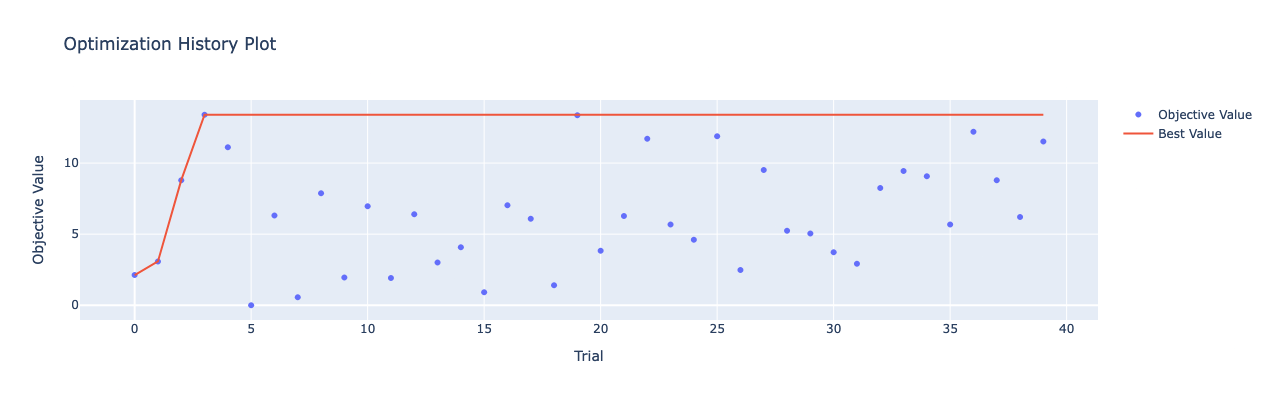

In [10]:
fig = optuna.visualization.plot_optimization_history(study)
fig.update_layout(height=400, width=1200)
fig.show()

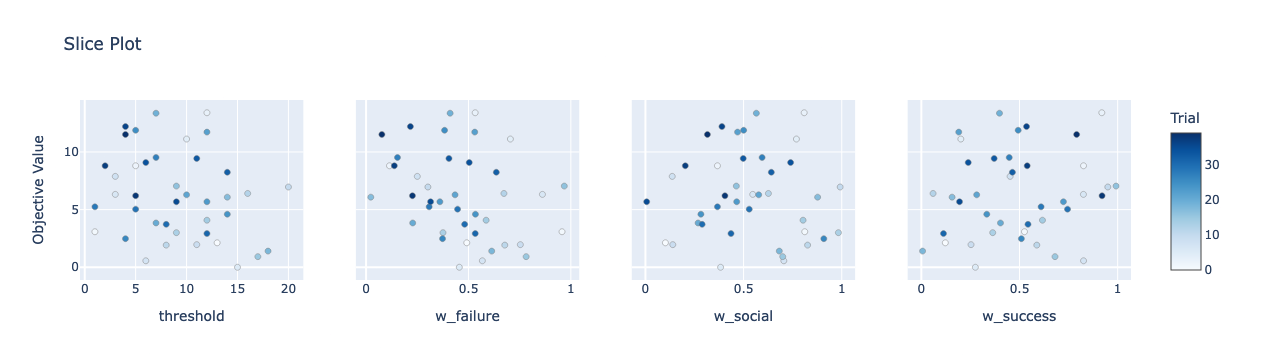

In [11]:
optuna.visualization.plot_slice(study, params=['w_social', 'w_success','w_failure', 'threshold'])

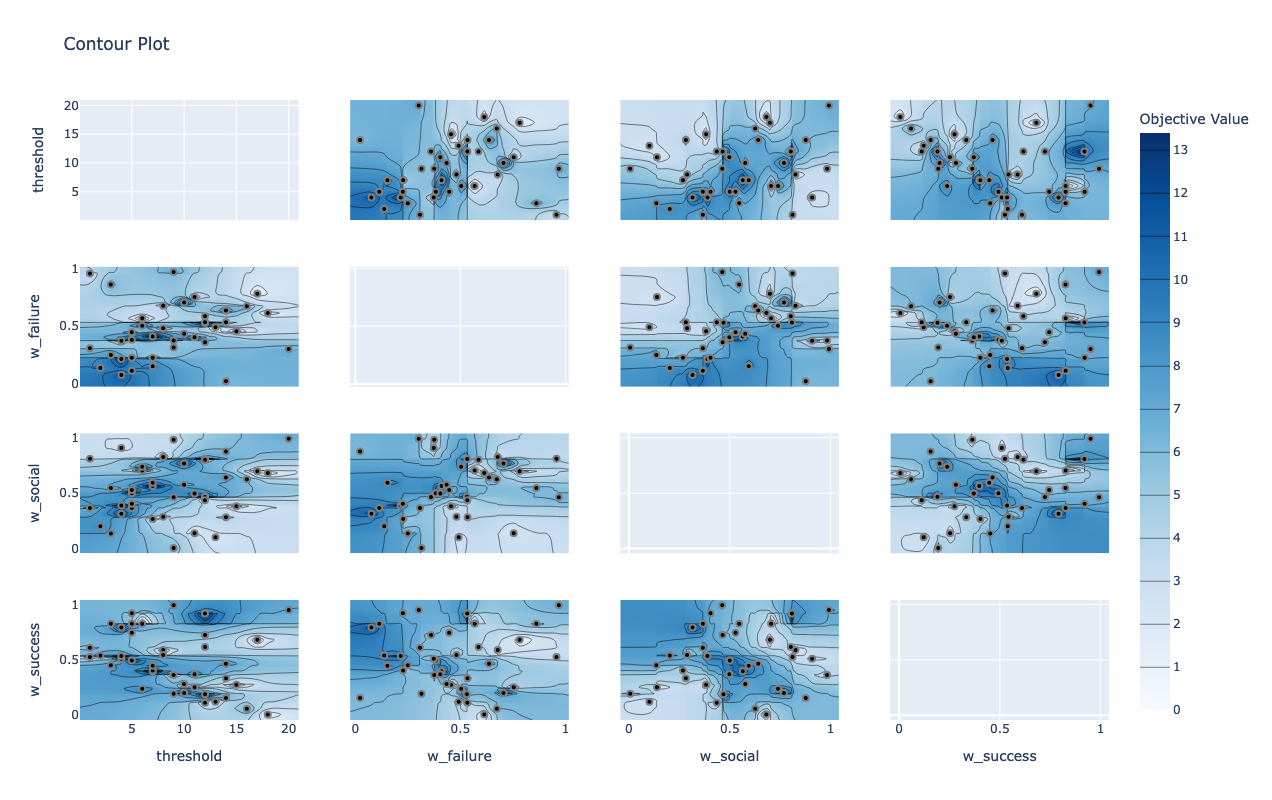

In [12]:
fig = optuna.visualization.plot_contour(study, params=['w_social', 'w_success','w_failure', 'threshold'])
fig.update_layout(height=800, width=1200)
fig.show()

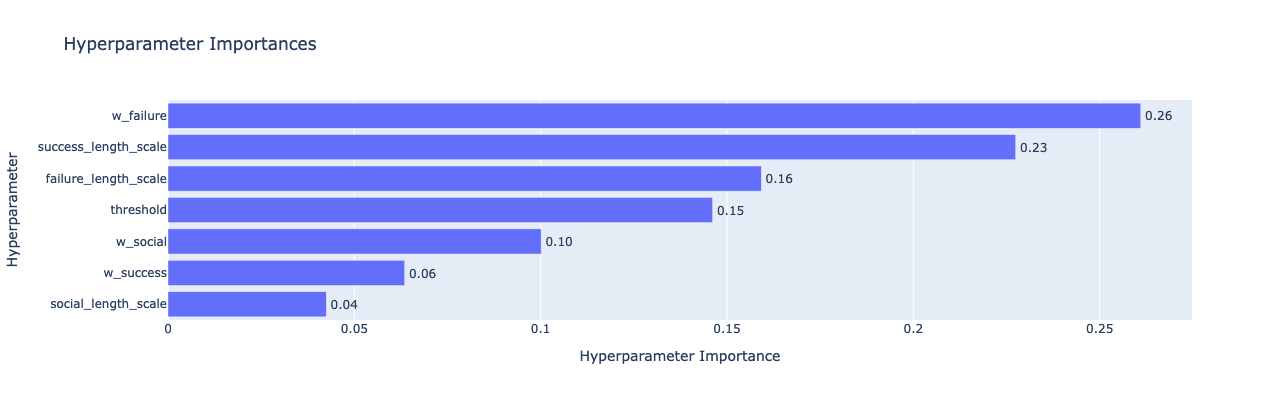

In [13]:
fig = optuna.visualization.plot_param_importances(study)
fig.update_layout(height=400, width=1200)
fig.show()

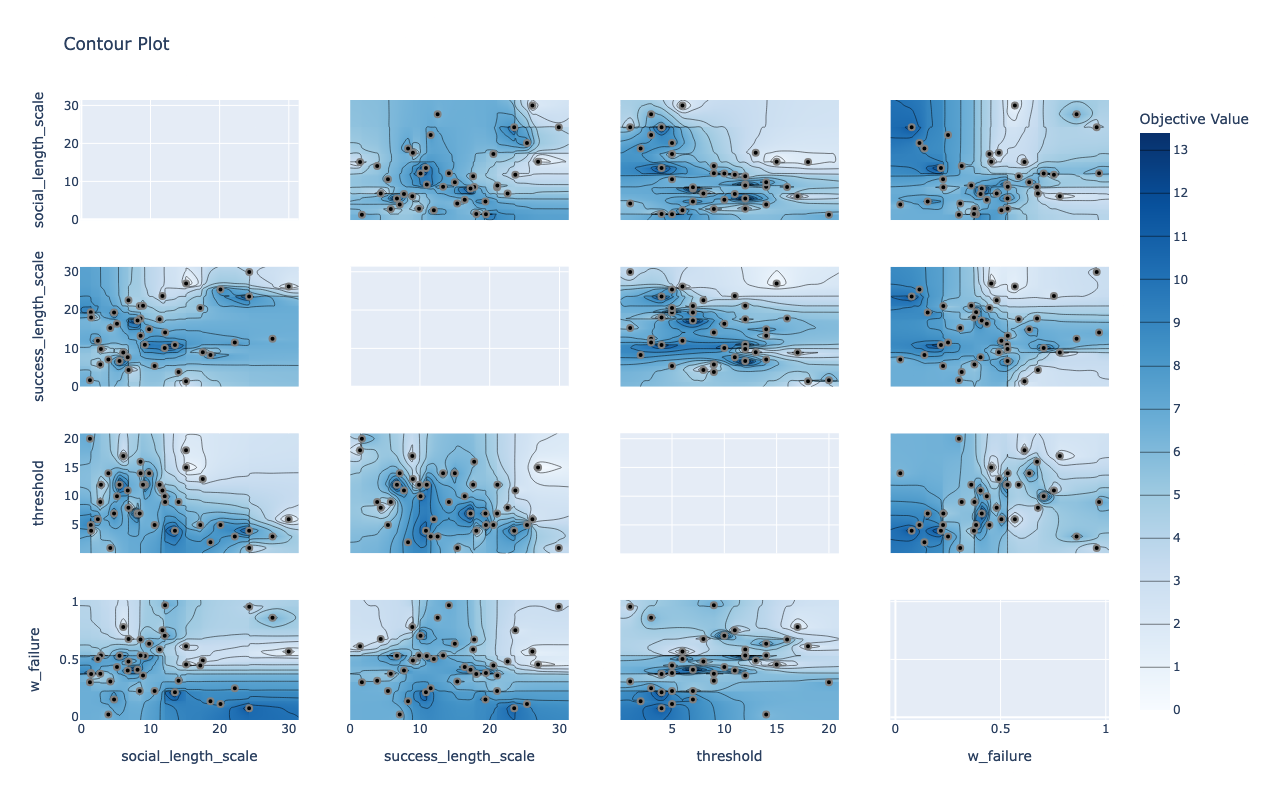

In [14]:
fig = optuna.visualization.plot_contour(study, params=['success_length_scale','w_failure', 'social_length_scale', 'threshold'])
# fig.show(renderer="browser")
fig.update_layout(height=800, width=1200)
fig.show()